# TODO


Think about normalization of the wavefunction and calculation of the expected values in cylindrical coordinates

# References

# Schrodinger Solver

In [3]:
%run Library/data_io.ipynb

Root Directory: 'C:\Users\hasbu\Desktop\Optics_of_2D_Materials\Python_Coding' 
  Library path: 'C:\Users\hasbu\Desktop\Optics_of_2D_Materials\Python_Coding\Library' 


In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import time
import sys
#from utils3 import *
import numpy as np
import pandas as pd
import math 
from scipy.special import struve, y0
from scipy.constants import e,epsilon_0,hbar,electron_mass
from scipy.signal import savgol_filter
from scipy.linalg import eig, eigh
np.set_printoptions(threshold=sys.maxsize)


In [5]:

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

figsize = (6,5); 

# Fonts
plt_label_size = 8; legend_font_size = plt_label_size*1 ; 

# Line thicknesses
axes_linewidth = 3; lines_linewidth = axes_linewidth; 

# Tick sizes
major_tick_size = 6; minor_tick_size = major_tick_size / 2; tick_width = major_tick_size / 4

kw_args = { 'figure.figsize' : figsize, # 'font.family' : 'cursive', # 'font.monospace' : 'Fixed',
           
            'axes.linewidth': axes_linewidth, 'lines.linewidth': lines_linewidth, 'axes.labelsize' : plt_label_size, 
           
            'axes.grid' : True, 'grid.alpha' : 0.25, 'grid.color' :  'gray', 'grid.linestyle': '--',
           
            'legend.fontsize': legend_font_size,  'legend.title_fontsize' : legend_font_size, 
            
           
            'xtick.direction':'in', 'xtick.major.size' : major_tick_size, 'xtick.major.width': tick_width, 'xtick.major.pad': major_tick_size, 
            'xtick.minor.size' : minor_tick_size, 'xtick.minor.width': tick_width, 'xtick.labelsize': plt_label_size, 'xtick.minor.visible': True,
            'xtick.color' : 'k', 'xtick.top': True,
             
            'ytick.direction':'in', 'ytick.major.size' : major_tick_size, 'ytick.major.width': tick_width, 'ytick.major.pad': major_tick_size,
            'ytick.minor.size' : minor_tick_size, 'ytick.minor.width': tick_width, 'ytick.labelsize': plt_label_size,  'ytick.minor.visible': True,
            'ytick.color' : 'k', 'ytick.right': True,
            
           }

plt.rcParams.update(kw_args)

# Potential

In [6]:
K_hBN = 4.5 # dielectric constant of hBN

def h0(x):
    return struve(0,x)

# Keldysh potential
def keldysh(r, r0=4.5*10**-9, K=1):
    r= abs(r)
    return -(e*e/(8*epsilon_0*r0) ) * (h0(K*r/r0)-y0(K*r/r0))
def harmonic_oscillator(x, mass, omega):
    return 0.5*mass* ((omega*x)**2)

## Keldysh Potential

###  Hamiltonian and Boundary Conditions

In [80]:
def solve_schrodinger_keldysh(screening_lengths = [ 7.5], reduced_masses = [0.16], K =[1] , 
                              w = 100, N = 100 ,
                             E_1s =0 # eV, quasi-particle gap,
                              ,sample = ''
                             ):
    
    start_time = time.time()
    E = []; F = []; parameters =[]
    xvec_nm =  xvec_nm = np.linspace( -0*w/N, w-0.000000*w/N, N)
    xvec =  xvec_nm * 10**-9
    factor = 1
    H = 4
    
    

    for k0 in screening_lengths:
        for reduced_mass in reduced_masses:
            for k in K:
                E_temp, F_temp, U = calculate_x_binding_keldysh_v1(k0 = k0, reduced_mass = reduced_mass , K=k, w=w, N=N)
                E.append(E_temp); F.append(F_temp)

                parameters.append([k0,reduced_mass])
                E_gap = E_1s - np.real(E_temp[0]) 
                
                #plt.figure(figsize=(H,H)); plt.rcParams.update({'font.size': 3*H})
                for n in [0,1,2]:
                    E_n = np.real(E_temp[n])

                    if F_temp[:,n][1] < 0: # Make the wavefunction positive at r(i=1)
                        F_temp[:,n] = -1*F_temp[:,n]

                    F_n_offset = [factor* f + E_gap + E_n for f in F_temp[:,n]]
                    plt.plot(xvec_nm, F_n_offset ,label='%ss: %.1f meV' %(n+1, 1000*E_n ), lw=3)
                    plt.plot( [0, w], [E_n + E_gap ,E_n + E_gap ], '--', lw=3)
                plt.plot(xvec_nm, [u + E_gap for u in U],label='Rytova–Keldysh', lw=3 )
                plt.plot([], [], ' ', label="r$_0$=%.2f nm, μ=%sm$_e$, K$_{%s}$=%s\nrange: %s nm (N=%s grids)" %(k0, reduced_mass,sample,k,w, N-1 ))
                legend = plt.legend(loc='lower right', title='2s-1s = %.1f meV \n3s-1s = %.1f meV\nΨx%s' %(1000*np.real(E_temp[1])-1000*np.real(E_temp[0]), 1000*np.real(E_temp[2])-1000*np.real(E_temp[0]),factor))
                #legend.get_title().set_fontsize('%s' %(2*H) )
                plt.xlim(0, 20); plt.xlabel('Radial Distance (nm)')
                plt.ylim( E_gap + np.real(E_temp[0]) - 0.05 , E_gap + 0.05 ); plt.ylabel('Energy (eV)')
                #plt.tick_params(direction='in', length=H, width=H/4)
                plt.title(sample)
                #figure(figsize=(25, 25))
                plt.show()
                
    end_time = time.time()

    print('ΔT = %.1f minutes' %( end_time/60 - start_time/60 ))
    
    return E, F, U, xvec

In [81]:
def calculate_x_binding_keldysh(k0 = 4.5, reduced_mass = 0.2, K = 1, w=100, N=100):
    
    xvec =  np.linspace( -0*w/N, w-0.000000*w/N, N) * 10**-9
    h = w/(N-1)* 10**-9
    
    exciton_mass = reduced_mass * electron_mass
    r0 =  k0 * 10**-9 # screening length

    Hamiltonian2=np.zeros((N,N))
    B2 = np.zeros((N,N))
    U_joules = [keldysh(xvec[0], r0, K)]

    for i in range(1, N-1):
        
        # 2nd derivative of the wavefunction
        Hamiltonian2[i,i-1] += -0.5*(hbar**2)/exciton_mass*(1/h**2); 
        Hamiltonian2[i,i]   += -0.5*(hbar**2)/exciton_mass*(-2/h**2) 
        Hamiltonian2[i,i+1] += -0.5*(hbar**2)/exciton_mass*(1/h**2)

        U_joules.append(keldysh(xvec[i], r0, K))
        Hamiltonian2[i,i] += U_joules[i]
        
        xvec_i = xvec[i]
        
        Hamiltonian2[i, i-1] += -(-0.5*(hbar**2)/exciton_mass*( 1/ xvec_i ) ) * (1/h)
        Hamiltonian2[i, i]   +=  (-0.5*(hbar**2)/exciton_mass*( 1/ xvec_i ) ) * (1/h)

        B2[i, i] = 1

    U_joules.append( keldysh(xvec[N-1], r0, K))

    U = [u/1.6*10**19 for u in U_joules]

    Hamiltonian2[0, 0]  = 1; Hamiltonian2[0, 1] = -1;  Hamiltonian2[0,2:]=0; B2[0, :] = 0 # derivative is 0 at r(i=0)
    #Hamiltonian2[0, 0]  = 0 # unknown boundary condition at r(i=0)
    Hamiltonian2[N-1,:] = 0; Hamiltonian2[N-1,N-1] = 1; B2[N-1, :] = 0 # wavefunction  is 0 at r(i=N-1)

    E_joules, G = eig(Hamiltonian2, B2)
    E = np.real(E_joules)
    E = E/1.6*10**19
    if N < 22:
        print(pd.DataFrame(Hamiltonian2))
        print(pd.DataFrame(B2))

    # order the solution in increasing eigenvalue
    order = np.argsort(E)
    E=np.take_along_axis(E, order, axis=0)
    F = G[:,order]
    return E, F, U

In [16]:
# Tim Berkelbach's suggestion
def calculate_x_binding_keldysh_v1(k0 = 4.5, reduced_mass = 0.2, K = 1, w=100, N=100):
    
    xvec =  np.linspace( -0*w/N, w-0.000000*w/N, N) * 10**-9
    h = w/(N-1)* 10**-9
    
    exciton_mass = reduced_mass * electron_mass
    r0 =  k0 * 10**-9 # screening length

    Hamiltonian2=np.zeros((N,N))
    B2 = np.zeros((N,N))
    U_joules = [keldysh(xvec[0], r0, K)]

    for i in range(1, N-1):
        
        # 2nd derivative of the wavefunction
        Hamiltonian2[i,i-1] += -0.5*(hbar**2)/exciton_mass*(1/h**2); 
        Hamiltonian2[i,i]   += -0.5*(hbar**2)/exciton_mass*(-2/h**2) 
        Hamiltonian2[i,i+1] += -0.5*(hbar**2)/exciton_mass*(1/h**2)

        U_joules.append(keldysh(xvec[i], r0, K))
        Hamiltonian2[i,i] += U_joules[i]

        Hamiltonian2[i, i]   +=  (-0.5*(hbar**2)/exciton_mass*( 1/ xvec[i]**2 ))
        
        xvec_i = xvec[i]
        
        Hamiltonian2[i, i-1] +=   (-0.5*(hbar**2)/exciton_mass*( 1/ xvec_i ) ) * (0.5/h)
        Hamiltonian2[i, i+1] +=  -(-0.5*(hbar**2)/exciton_mass*( 1/ xvec_i ) ) * (0.5/h)

        B2[i, i] = 1

    U_joules.append( keldysh(xvec[N-1], r0, K))

    U = [u/1.6*10**19 for u in U_joules]

    Hamiltonian2[0, 0]  = 1;  Hamiltonian2[0,1:]=0; B2[0, :] = 0 # wavefunction is 0 at r(i=0)
    Hamiltonian2[N-1,N-1] = 1; Hamiltonian2[N-1,1:] = 0; B2[N-1, :] = 0 # wavefunction  is 0 at r(i=N-1)

    E_joules, G = eig(Hamiltonian2, B2)
    E = np.real(E_joules)
    E = E/1.6*10**19
    if N < 22:
        print(pd.DataFrame(Hamiltonian2))
        print(pd.DataFrame(B2))

    # order the solution in increasing eigenvalue
    order = np.argsort(E)
    E=np.take_along_axis(E, order, axis=0)
    
    F = G[:,order]
    F = F/xvec[:,None]*10**-9 # change back to the wavefunction
    
    return E, F, U

In [17]:
# Tim Berkelbach's suggestion + My change
def calculate_x_binding_keldysh_v2(k0 = 4.5, reduced_mass = 0.2, K = 1, w=100, N=100):
    
    xvec =  np.linspace( -0*w/N, w-0.000000*w/N, N) * 10**-9
    h = w/(N-1)* 10**-9
    
    exciton_mass = reduced_mass * electron_mass
    r0 =  k0 * 10**-9 # screening length

    Hamiltonian2=np.zeros((N,N))
    B2 = np.zeros((N,N))
    U_joules = [keldysh(xvec[0], r0, K)]

    for i in range(1, N-1):
        
        # 2nd derivative of the wavefunction
        Hamiltonian2[i,i-1] += -0.5*(hbar**2)/exciton_mass*(1/h**2); 
        Hamiltonian2[i,i]   += -0.5*(hbar**2)/exciton_mass*(-2/h**2) 
        Hamiltonian2[i,i+1] += -0.5*(hbar**2)/exciton_mass*(1/h**2)

        U_joules.append(keldysh(xvec[i], r0, K))
        Hamiltonian2[i,i] += U_joules[i]

        Hamiltonian2[i, i]   +=  (-0.5*(hbar**2)/exciton_mass*( 0.25/ xvec[i]**2 ))
        
        xvec_i = xvec[i]

        B2[i, i] = 1

    U_joules.append( keldysh(xvec[N-1], r0, K))

    U = [u/1.6*10**19 for u in U_joules]

    Hamiltonian2[0, 0]  = 1;  Hamiltonian2[0,1:]=0; B2[0, :] = 0 # wavefunction is 0 at r(i=0)
    Hamiltonian2[N-1,N-1] = 1; Hamiltonian2[N-1,1:] = 0; B2[N-1, :] = 0 # wavefunction  is 0 at r(i=N-1)

    E_joules, G = eig(Hamiltonian2, B2)
    E = np.real(E_joules)
    E = E/1.6*10**19
    if N < 22:
        print(pd.DataFrame(Hamiltonian2))
        print(pd.DataFrame(B2))

    # order the solution in increasing eigenvalue
    order = np.argsort(E)
    E=np.take_along_axis(E, order, axis=0)
    
    F = G[:,order]
    F = F/math.sqrt(xvec[:,None])*10**-4.5 # change back to the wavefunction
    
    return E, F, U

### "Exciton Binding Energy and Nonhydrogenic Rydberg Series in Monolayer WS$_2$"

In [9]:
#F[0][:,0]

In [10]:
# Tim's Hamiltonian
E, F = solve_schrodinger_keldysh(screening_lengths = [7.5], reduced_masses = [0.16], K =[1] , w = 20, N = 801, E_1s = 2.41)


KeyboardInterrupt



In [ ]:
# Tim's Hamiltonian
E, F = solve_schrodinger_keldysh(screening_lengths = [7.5], reduced_masses = [0.16], K =[1] , w = 40, N = 1601, E_1s = 2.41)

In [ ]:
F[0][:,0]

In [ ]:
# Tim's Hamiltonian
E, F = solve_schrodinger_keldysh(screening_lengths = [7.5], reduced_masses = [0.16], K =1 , w = 40, N = 2001, E_1s = 2.41)

### Magneto-Optics of Exciton Rydberg States in a Monolayer Semiconductor

In [ ]:
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [4.5], reduced_masses = [0.20], K =4.5 , w = 80, N = 2001, E_1s = 1.66)

In [ ]:
# expected value of the radius of nth state
F_temp = F[0]

reduced_mass = 0.2
k0 = 4.5
K=4.5
n = [0,1,2,3]
r_n = [0]*len(n)
r_rms_n = [0]*len(n)
print('r0=%.2f nm, μ=%s, K=%s' %(k0,reduced_mass,K))
for j in n:
    normalization=0
    for i in range(1, len(xvec)):
        r_n[j] += 2* np.pi* np.conj(F_temp[i,j]) * xvec[i] * xvec[i] * F_temp[i,j]
        r_rms_n[j] += 2* np.pi* np.conj(F_temp[i,j]) * xvec[i] *xvec[i] * xvec[i] * F_temp[i,j]
        normalization += 2* np.pi * xvec[i] * np.conj(F_temp[i,j]) * F_temp[i,j] 
    print( 'r: %s, r_rms = %s, normalization: %s' %(r_n[j]/normalization, np.sqrt(r_rms_n[j]/normalization), normalization))

In [ ]:
E, F = solve_schrodinger_keldysh(screening_lengths = [4.5], reduced_masses = [0.20], K =4.5 , w = 80, N = 4001, E_1s = 1.83)

In [ ]:
With derivative 
Hamiltonian2[i, i-1] +=   (-0.5*(hbar**2)/exciton_mass*( 1/ xvec_i ) ) * (0.5/h)
Hamiltonian2[i, i+1] +=  -(-0.5*(hbar**2)/exciton_mass*( 1/ xvec_i ) ) * (0.5/h)
E, F = solve_schrodinger_keldysh(screening_lengths = [4.5], reduced_masses = [0.20], K =4.5 , w = 80, N = 2001, E_1s = 1.83)

### Spatial extent of the excited exciton states in ${\rm WS}_2$ monolayers from diamagnetic shifts


In [ ]:
start_time = time.time()
E = []; F = []; parameters =[]

reduced_masses = [0.15]
screening_lengths = [ 4.]
K = 4.5

factor = .3
plt.figure(figsize=(6,6))

for k0 in screening_lengths:
    for reduced_mass in reduced_masses:
        E_temp, F_temp = calculate_x_binding_keldysh(k0 = k0, reduced_mass = reduced_mass , K=K)
        E.append(E_temp); F.append(F_temp)

        parameters.append([k0,reduced_mass])
        for n in [0,1]:
            E_n = np.real(E_temp[n])
            F_n_offset = [factor* f + E_n for f in F_temp[:,n]]

            plt.plot(xvec, F_n_offset ,label='%ss' %(n+1) +' %.1f meV' %(1000*E_n ))
            plt.plot( [0, w*10 **-9], [E_n ,E_n ], '--')
            plt.xlim(0*10**-9, 20*10**-9)
            plt.legend(loc='lower right', title='2s-1s = %.1f meV \n3s-2s = %.1f meV \nr0=%.2f nm, μ=%s, K=%s\nΨx%s\nN=%s' %(1000*np.real(E_temp[1])-1000*np.real(E_temp[0]), 1000*np.real(E_temp[2])-1000*np.real(E_temp[1]) ,k0, reduced_mass, K,factor,N ))
        plt.show()
end_time = time.time()

print('ΔT = %.1f minutes' %( end_time/60 - start_time/60 ))

### Suspended 2L WSe$_2$

In [ ]:
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [9.3], reduced_masses = [0.28], K = [1] , w = 20, N = 1001, E_1s = 1.64)

### 1L WS$_2$ on PDMS

References:
    
   Reduced Mass: https://doi.org/10.1021/acsnano.9b08004
   
   https://doi.org/10.1103/PhysRevLett.113.076802
 

#### Fit with K

In [66]:
print(u'WS\u2082')  # H₂SO₄


WS₂


In [67]:
sample = u'WS\u2082'

In [68]:
print(sample)

WS₂


C:\Users\hasbu\AppData\Local\Temp\ipykernel_13488\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_13488\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


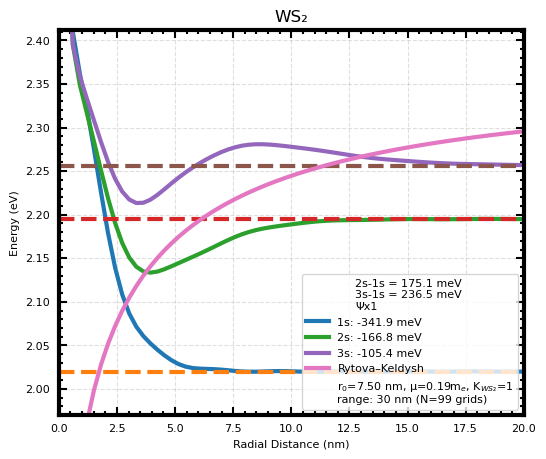

ΔT = 0.0 minutes


In [82]:

E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [7.5], reduced_masses = [0.19], K =[1] , w = 30, N = 1001, E_1s = 2.02, sample = u'WS\u2082')

#### Fit with r0

In [ ]:
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [6.8], reduced_masses = [0.23], K =[1.9] , w = 20, N = 1001, E_1s = 1.67)

In [ ]:
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [6.7], reduced_masses = [0.23], K =[1.9] , w = 20, N = 1001, E_1s = 1.67)

### Suspended 1L WSe$_2$

In [ ]:
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [6.1], reduced_masses = [0.23], K =[1] , w = 20, N = 2001, E_1s = 1.68)

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


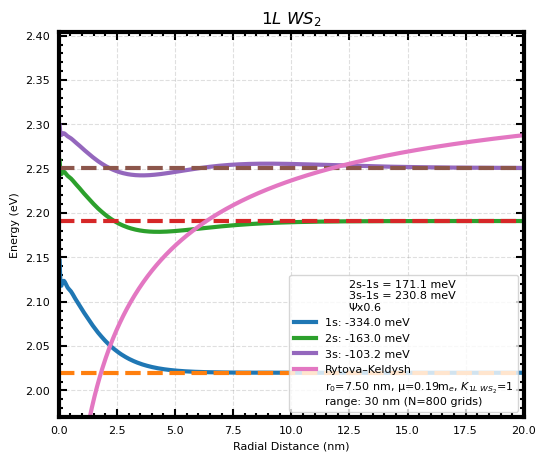

ΔT = 0.1 minutes


In [71]:
r0 = 7.5; μ = 0.19; K = 1; Width = 30; N = 801
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [r0], reduced_masses = [μ], K =[K], w = Width, N = N, E_1s = 2.02)

In [ ]:
#U, xvec

In [ ]:
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [6.15], reduced_masses = [0.24], K =[1] , w = 80, N = 8001, E_1s = 1.68)

In [ ]:
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [6.15], reduced_masses = [0.24], K =[1] , w = 80, N = 8001, E_1s = 1.68)

In [ ]:
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [6.15], reduced_masses = [0.24], K =[1] , w = 20, N = 8001, E_1s = 1.68)

In [ ]:
r0 = 6.15; μ = 0.23; K = 1
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [r0], reduced_masses = [μ], K =[K], w = 20, N = 8001, E_1s = 1.68)

In [ ]:
r0 = 6.1; μ = 0.23; K = 1
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [6.1], reduced_masses = [0.23], K =[1] , w = 20, N = 2001, E_1s = 1.68)

In [ ]:
r0 = 6.15; μ = 0.24; K = 1; Width = 20; N = 801
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [r0], reduced_masses = [μ], K =[K], w = Width, N = N, E_1s = 1.68)

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


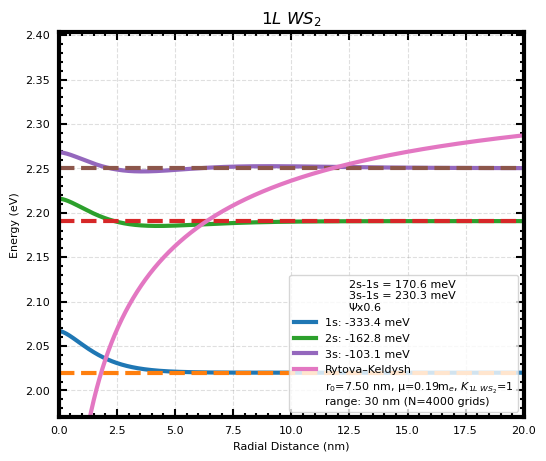

ΔT = 16.1 minutes


In [72]:
r0 = 7.5; μ = 0.19; K = 1; Width = 30; N = 4001; E_1s = 2.09
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = [r0], reduced_masses = [μ], K =[K] , w = Width, N = N, E_1s = 2.02)

In [ ]:
r0 = 6.1; μ = 0.23; K = 1; Width = 80; N = 4001; E_1s = 1.68

In [73]:
# expected value of the radius of nth state
F_temp = F[0]

n = [0,1,2,3]
r_n = [0]*len(n)
r_rms_n = [0]*len(n)
print('%s grids,0-%s nm' %(len(xvec), xvec[-1]*10**9))
print('r0=%.2f nm, μ=%s, K=%s' %(r0,μ,K))
for j in n:
    normalization=0
    for i in range(1, len(xvec)):
        r_n[j] += 2* np.pi* np.conj(F_temp[i,j]) * xvec[i] * xvec[i] * F_temp[i,j]
        r_rms_n[j] += 2* np.pi* np.conj(F_temp[i,j]) * xvec[i] *xvec[i] * xvec[i] * F_temp[i,j]
        normalization += 2* np.pi * xvec[i] * np.conj(F_temp[i,j]) * F_temp[i,j] 
    print( 'r_%ss: %s, r_rms = %s, normalization: %s' %(j+1,r_n[j]/normalization, np.sqrt(r_rms_n[j]/normalization), normalization))

4001 grids,0-30.000000000000004 nm
r0=7.50 nm, μ=0.19, K=1
r_1s: 1.3990986698653517e-09, r_rms = 1.6413861129729573e-09, normalization: 4.490880766675513e-09
r_2s: 3.542147855562077e-09, r_rms = 4.327995629813553e-09, normalization: 1.7738348491899877e-09
r_3s: 6.031703159955113e-09, r_rms = 7.511163432607482e-09, normalization: 1.0416933891730722e-09
r_4s: 8.946507014484305e-09, r_rms = 1.1238093040835885e-08, normalization: 7.023059722646143e-10


In [74]:
# expected value of the radius of nth state
F_temp = F[0]
k0 = 4.5
reduced_mass = r0
n = [0,1,2,3]
r_n = [0]*len(n)
r_rms_n = [0]*len(n)
print('%s grids,0-%s nm' %(len(xvec), xvec[-1]*10**9))
print('r0=%.2f nm, μ=%s, K=%s' %(k0,reduced_mass,K))
for j in n:
    normalization=0
    for i in range(1, len(xvec)):
        r_n[j] += 2* np.pi* np.conj(F_temp[i,j]) * xvec[i] * xvec[i] * F_temp[i,j]
        r_rms_n[j] += 2* np.pi* np.conj(F_temp[i,j]) * xvec[i] *xvec[i] * xvec[i] * F_temp[i,j]
        normalization += 2* np.pi * xvec[i] * np.conj(F_temp[i,j]) * F_temp[i,j] 
    print( 'r: %s, r_rms = %s, normalization: %s' %(r_n[j]/normalization, np.sqrt(r_rms_n[j]/normalization), normalization))

4001 grids,0-30.000000000000004 nm
r0=4.50 nm, μ=7.5, K=1
r: 1.3990986698653517e-09, r_rms = 1.6413861129729573e-09, normalization: 4.490880766675513e-09
r: 3.542147855562077e-09, r_rms = 4.327995629813553e-09, normalization: 1.7738348491899877e-09
r: 6.031703159955113e-09, r_rms = 7.511163432607482e-09, normalization: 1.0416933891730722e-09
r: 8.946507014484305e-09, r_rms = 1.1238093040835885e-08, normalization: 7.023059722646143e-10


In [75]:
# expected value of the radius of nth state
F_temp = F[0]

n = [0,1,2,3]
r_n = [0]*len(n)
r_rms_n = [0]*len(n)
print('%s grids,0-%s nm' %(len(xvec), xvec[-1]*10**9))
print('r0=%.2f nm, μ=%s, K=%s' %(k0,reduced_mass,K))
for j in n:
    normalization=0
    for i in range(1, len(xvec)):
        r_n[j] += 2* np.pi* np.conj(F_temp[i,j]) * xvec[i] * xvec[i] * F_temp[i,j]
        r_rms_n[j] += 2* np.pi* np.conj(F_temp[i,j]) * xvec[i] *xvec[i] * xvec[i] * F_temp[i,j]
        normalization += 2* np.pi * xvec[i] * np.conj(F_temp[i,j]) * F_temp[i,j] 
    print( 'r: %s, r_rms = %s, normalization: %s' %(r_n[j]/normalization, np.sqrt(r_rms_n[j]/normalization), normalization))

4001 grids,0-30.000000000000004 nm
r0=4.50 nm, μ=7.5, K=1
r: 1.3990986698653517e-09, r_rms = 1.6413861129729573e-09, normalization: 4.490880766675513e-09
r: 3.542147855562077e-09, r_rms = 4.327995629813553e-09, normalization: 1.7738348491899877e-09
r: 6.031703159955113e-09, r_rms = 7.511163432607482e-09, normalization: 1.0416933891730722e-09
r: 8.946507014484305e-09, r_rms = 1.1238093040835885e-08, normalization: 7.023059722646143e-10


In [ ]:
Width

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


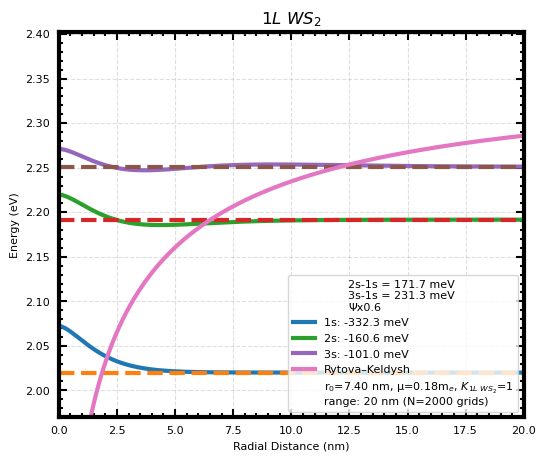

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


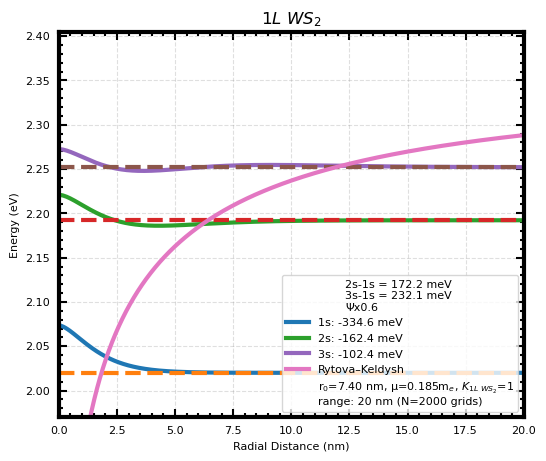

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


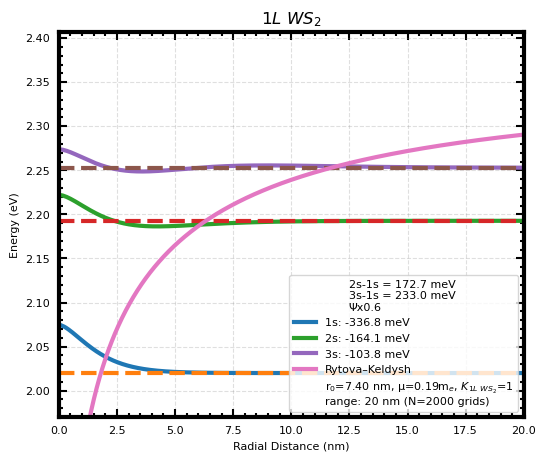

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


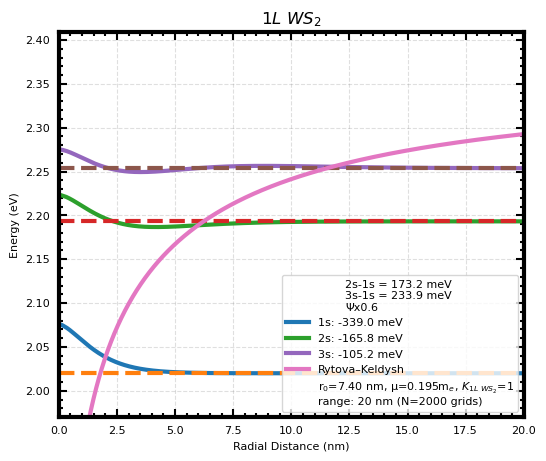

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


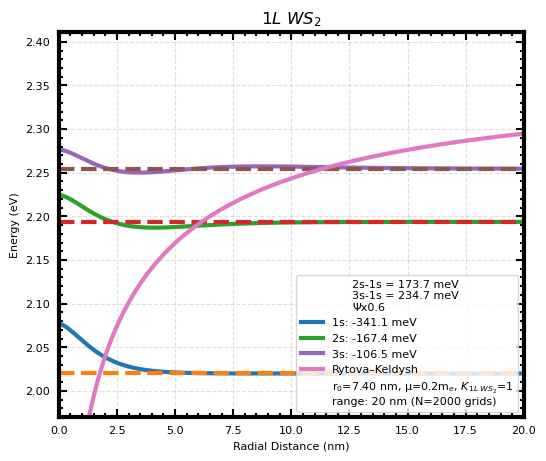

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


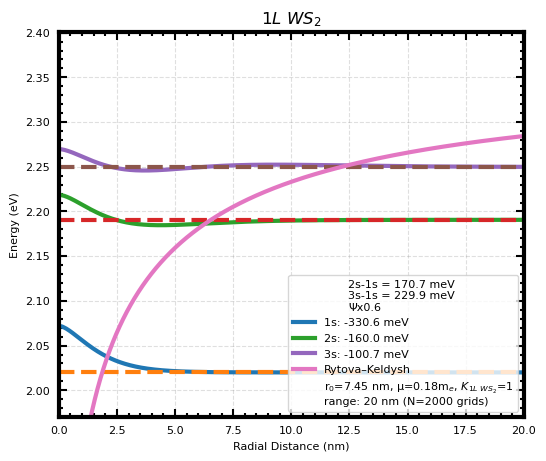

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


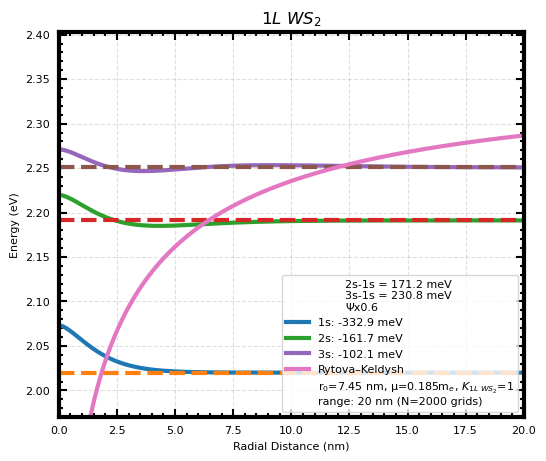

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


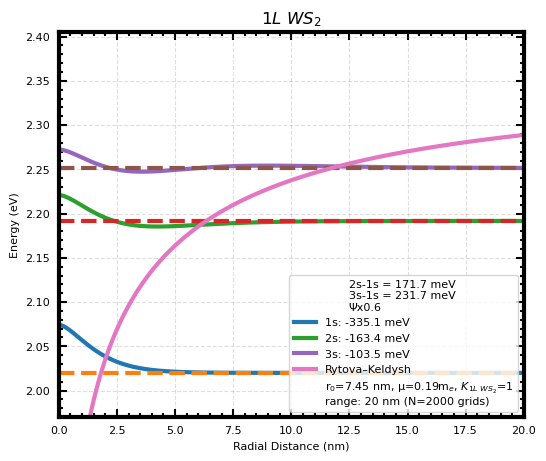

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


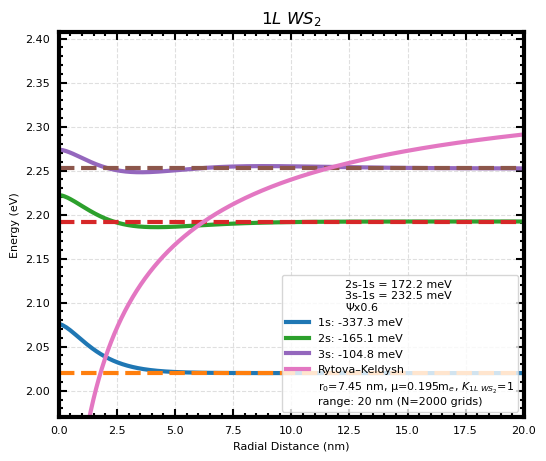

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


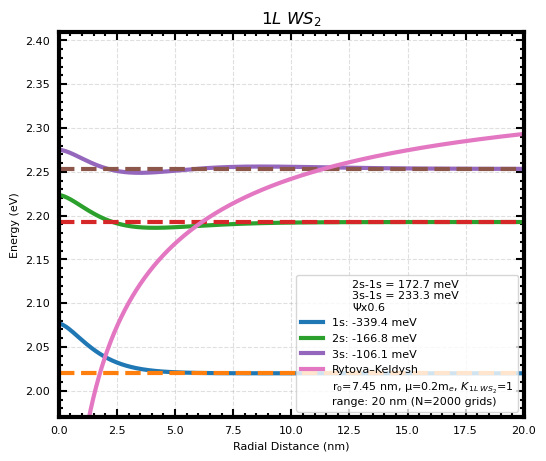

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


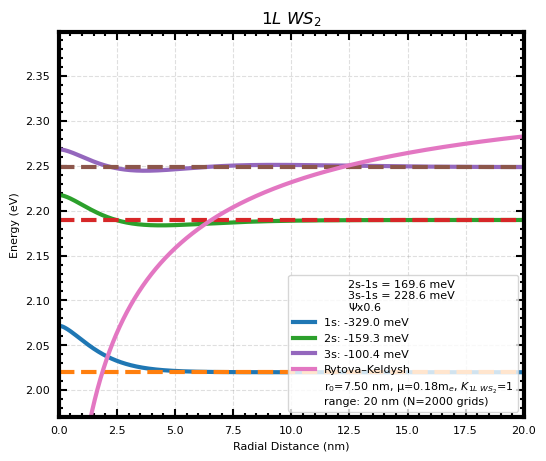

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


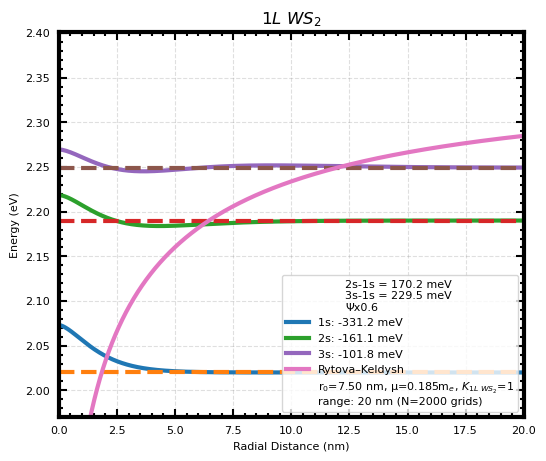

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


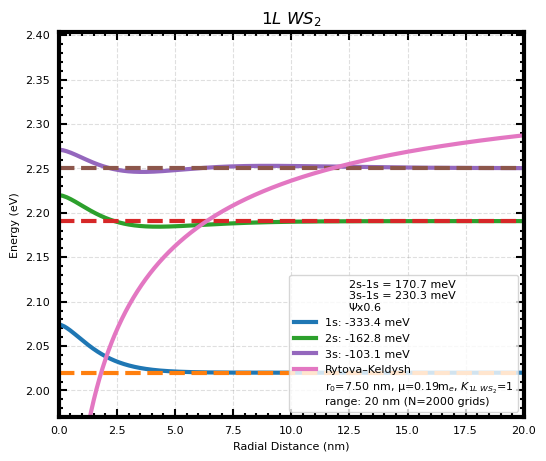

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


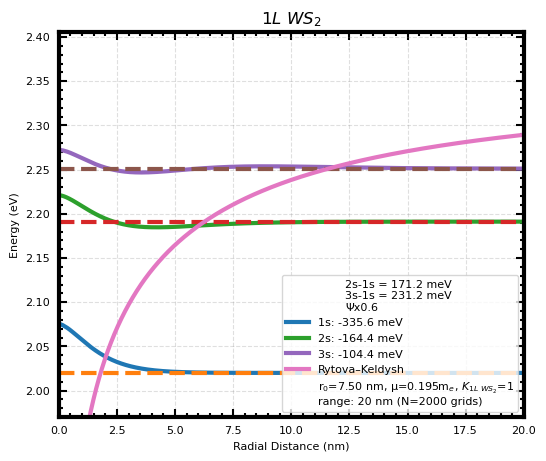

C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: divide by zero encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction
C:\Users\hasbu\AppData\Local\Temp\ipykernel_23340\3852716118.py:52: RuntimeWarning: invalid value encountered in true_divide
  F = F/xvec[:,None]*10**-9 # change back to the wavefunction


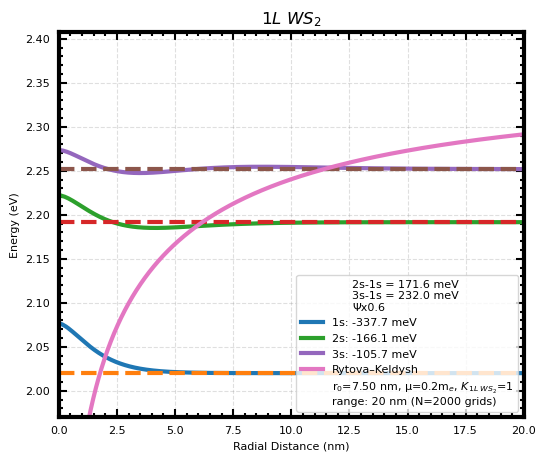

In [ ]:
screening_lengths = [7.40, 7.45, 7.50, 7.55, 7.60]; reduced_masses = [0.180, 0.185, 0.19, 0.195, 0.20] ; K = 1
E, F, U, xvec = solve_schrodinger_keldysh(screening_lengths = screening_lengths, reduced_masses = reduced_masses, K =[K] , w = 20, N = 2001, E_1s = 2.02)


In [ ]:
print("%s nm (N = %s)" % (xvec[-1]*10**9, len(xvec)) )
np.array_split([e[0] for e in E], len(reduced_masses)) ; [e[0] for e in E]

X,Y = reduced_masses, screening_lengths
E1s_QEH = 412; E2s_QEH = 206; E1s_2s_exp = 209; E1s_3s_exp = 282 ; 
E1s    = np.array_split([-e[0]*1000 for e in E], len(Y)) 
E2s    = np.array_split([-e[1]*1000 for e in E], len(Y)) 
E1s_2s = np.array_split([(e[1]-e[0])*1000 for e in E], len(Y)) #[e2s-e1s for e2s,e1s in zip(E2s,E1s)]
E1s_3s = np.array_split([(e[2]-e[0])*1000 for e in E], len(Y)) 

kwargs ={'colors':'w', 'fontsize':10, 'inline': True}

fig, ((ax1,ax3), (ax2, ax4)) = plt.subplots(2, 2, constrained_layout=True,figsize=(20,20) )

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xlabel('Exciton reduced mass (m$_e$)'); ax.set_ylabel('Screening length (nm)')
    ax.set_xticks(reduced_masses); ax.set_yticks(screening_lengths)

                        
#ax1.set_title('ΔE$_{2s-1s}$ (meV) [Exp.:%s meV]' %E1s_2s_exp)
cp_1s_2s = ax1.contourf(X, Y , E1s_2s, cmap='viridis')
ax1.clabel(cp_1s_2s, **kwargs); fig.colorbar(cp_1s_2s, ax=ax1)

#ax3.set_title('ΔE$_{3s-1s}$ (meV) [Exp.:%s meV]' %E1s_3s_exp)
cp_2s_3s =ax3.contourf(X, Y , E1s_3s, cmap='viridis')
ax3.clabel(cp_2s_3s, **kwargs); fig.colorbar(cp_2s_3s, ax=ax3)

cp_1s =ax2.contourf(X, Y , E1s, cmap='plasma')
#ax2.set_title('E$_{1s}^{binding}$ (meV) [QEH:%s meV]' %E1s_QEH)
ax2.clabel(cp_1s, **kwargs); fig.colorbar(cp_1s, ax=ax2)

cp_2s =ax4.contourf(X, Y , E2s, cmap='plasma')
#ax4.set_title('E$_{2s}^{binding}$ (meV)[QEH:%s meV]' %E2s_QEH)
ax4.clabel(cp_2s, **kwargs); fig.colorbar(cp_2s, ax=ax4)

plt.show()

In [ ]:
X,Y = reduced_masses, screening_lengths
E1s_2s = np.array_split([(e[1]-e[0])*1000 for e in E], len(Y)) 
E2s_3s = np.array_split([(e[2]-e[1])*1000 for e in E], len(Y)) 
cp_1s_2s =plt.contourf(X, Y , E1s_2s)

kwargs ={'colors':'w', 'fontsize':10, 'inline': True}
plt.colorbar(cp_1s_2s); plt.clabel(cp_1s_2s, **kwargs)
plt.show()
cp_2s_3s =plt.contourf(X, Y , E2s_3s)
plt.colorbar(cp_2s_3s); plt.clabel(cp_2s_3s, **kwargs)
plt.show()

In [ ]:
E[0][0:4]

In [ ]:
len(xvec)

In [ ]:
W

In [ ]:
wavefunctions_pd = pd.DataFrame( F_temp[:, 0:4], columns =['1s','2s','3s','4s'])
wavefunctions_pd.insert(loc=0, column='Keldysh Potential (eV)', value=U)
wavefunctions_pd.insert(loc=0, column='Radial distance (nm)', value=xvec)
wavefunction_name = 'Suspended 1L WSe2_1s-4s_r0=%snm_m=%s_w=%snm_N=%s grids' %(r0, μ, Width, len(xvec)-1)
wavefunction_name

## Export the Wavefunction

In [ ]:
wavefunctions_pd = pd.read_csv(r"C:\Users\hasbu\Desktop\experiment_results\Python_Coding\Inputs\WS2\Wavelength.csv")
wavefunctions_pd

### Hamiltonian by A. Stier et al.
https://arxiv.org/pdf/1709.00123.pdf  
Magnetooptics of Exciton Rydberg States in a Monolayer Semiconductor

In [ ]:
from scipy.constants import e,epsilon_0,hbar,electron_mass
w = 20
xvec =  np.linspace( 0.00, w, 40) * 10**-9
h = xvec[1]-xvec[0]
N= len(xvec)
exciton_mass = 0.2*electron_mass

Hamiltonian=np.zeros((2*N,2*N))
B = np.zeros((2*N,2*N))
for i in range(0,N-1):
    
    ## Eq. 11
    Hamiltonian[i,i] += 0.5; Hamiltonian[i,i+1] += 0.5    
    Hamiltonian[i,N+i] += 1/h; Hamiltonian[i,N+i+1] += -1/h    
    
    # Eq. 12
    Hamiltonian[N+i,i+1] += (-0.5)*((hbar**2)/exciton_mass)/h 
    Hamiltonian[N+i,i] +=  -(-0.5)*((hbar**2)/exciton_mass)/h 

    Hamiltonian[N+i,i+1] += (-0.5)*((hbar**2)/exciton_mass)/(xvec[i+1]+xvec[i])
    Hamiltonian[N+i,i]  +=  (-0.5)*((hbar**2)/exciton_mass)/(xvec[i+1]+xvec[i]) 
    
    # Eq. 12, Keldysh potential (typo in that equation)
    #print(keldysh( (xvec[i+1]+xvec[i])/2 ,r0))
    Hamiltonian[N+i,N+i]   += keldysh( (xvec[i+1]+xvec[i])/2 )/2
    Hamiltonian[N+i,N+i+1] += keldysh( (xvec[i+1]+xvec[i])/2 )/2
    
    # Eq. 12, RHS
    B[N+i,N+i]   += 0.5
    B[N+i,N+i+1] += 0.5
    
Hamiltonian[2*N-1,:] = 0; Hamiltonian[2*N-1,2*N-1]=1; B[2*N-1,:] = 0 # boundary condition, ψ=0 at r(i=N-1)
Hamiltonian[N-1, : ] = 0; Hamiltonian[N-1, 0 ]= 1;    B[N-1,:] = 0 # boundary condition, ϕ=0 at r(i=0)

pd.DataFrame(Hamiltonian)


In [ ]:
E_joules, G = eig(Hamiltonian, B)
E = np.real(E_joules)
E = E/1.6*10**19

# order the solution in increasing eigenvalue
order = np.argsort(E)
E=np.take_along_axis(E, order, axis=0)
F = G[:,order]

In [ ]:
[e for e in E[0:N] if e<0 ]

In [ ]:
factor = 0.1
for n in [1]:
    E_n = np.real(E[n])
    F_n_offset = [factor* f + E_n for f in F[:,n]]
    plt.plot(np.repeat(xvec,1), F_n_offset ,label='%ss (x%s)' %(n+1,factor) +' %.1f meV' %(1000*E_n ))
    plt.plot( [0, w*10 **-9], [E_n ,E_n ])
    #plt.plot(xvec, U, label='Keldysh(r0=%f)' %r0*10**9)
plt.xlim(0*10**-9,20*10**-9)
plt.legend()
plt.show()

In [ ]:
len(np.repeat(xvec,1))

In [ ]:
len(F_n_offset)

In [ ]:
# create Laplacian via 3-point finite-difference method
Laplacian=(-2.0*np.diag(np.ones(steps)) + np.diag(np.ones(steps-1),1) + np.diag(np.ones(steps-1),-1))/(float)(h**2)

L2D = ( (np.diag(np.ones(steps-1),1) - np.diag(np.ones(steps-1),-1))/(float)(2*h) )
for i in range(len(L2D)):
    L2D[i] = L2D[i]/ xvec[i]
    
# create the Hamiltonian
Hamiltonian=np.zeros((steps,steps))
[i,j] = np.indices(Hamiltonian.shape)
Hamiltonian[i==j]=U
Hamiltonian +=(-0.5)*((hbar**2)/exciton_mass)*(Laplacian+L2D)

# diagonalize the Hamiltonian yielding the wavefunctions and energies
E,V=diagonalize_hamiltonian(Hamiltonian)
# determine theoretical number of energy levels (n)
n=0
while E[n]<0:
    n +=1

In [ ]:
E, F = eig(Hamiltonian,B)
E_real = np.real(E[N:]/1.6*10**19)

## Infinite 1D well

In [ ]:
########
# PARTICLE IN AN INFINITE POTENTIAL WELL
########
Case=1
########
# INPUT
########
steps = 100
m =1; hbar =1
# set well width and number of wave functions desired
W=1.0 # this value must be between 0.5 and 15
n=7 # this value must be any integer greater than or equal to 1
########
# CODE
########
# divide by two so a well from -W to W is of input width
W=W / 1.0
# create x-vector from -W to W
xvec=np.linspace(-W,W,steps,dtype=np.float_)
# get step size
h=xvec[1]-xvec[0]
# create Laplacian via 3 point finite-difference method
Laplacian=(-2.0*np.diag(np.ones(steps))+np.diag(np.ones(steps-1),1)\
    +np.diag(np.ones(steps-1),-1))/(float)(h**2)
# create Hamiltonian
Hamiltonian=((-0.5*(hbar**2)/m))*Laplacian
# diagonalize the Hamiltonian yielding the wavefunctions and energies
E,V=diagonalize_hamiltonian(Hamiltonian)
# print output
output(Case,['Well Width','Number of wavefunctions to plot'],[W*2,n],E,n)
# create plot
infinite_well_plot(E,V,xvec,W,steps,n,Case)

In [ ]:
from scipy.constants import e,epsilon_0,hbar,electron_mass
w = 2
xvec =  np.arange( 0, w+0.1, 0.1) * 10**-9
h = xvec[1]-xvec[0]

N = len(xvec)
Hamiltonian2 = np.zeros((N,N))
B2 = np.zeros((N,N))

for i in range(1, N-1):
    
    Hamiltonian2[i,i-1]= -0.5*(hbar**2)/exciton_mass*(1/h**2); 
    Hamiltonian2[i,i]  = -0.5*(hbar**2)/exciton_mass*(-2/h**2) 
    Hamiltonian2[i,i+1]= -0.5*(hbar**2)/exciton_mass*(1/h**2)
    
    B2[i, i] = 1

B2[0, 0] = 0
B2[N-1, N-1] = 0

Hamiltonian2[0, 0]= 1;
Hamiltonian2[N-1,N-1] = 1
E_joules, G = eig(Hamiltonian2, B2)
E = np.real(E_joules)
E = E/1.6*10**19

# order the solution in increasing eigenvalue
order = np.argsort(E)
E=np.take_along_axis(E, order, axis=0)
F = G[:,order]

In [ ]:
n = 1
E_n = np.real(E[n])
F_n_offset = [100* f + E_n for f in F[:,n]]
plt.plot(xvec, F_n_offset ,label='Ψ n = %s (x100, offset)' %(n))
plt.plot( [0, w*10 **-9], [E_n ,E_n ], label='E[n=%d] = %.2f meV' %(n,E_n ))
plt.legend()
plt.show()

## Harmonic Oscillator
Zero Wavefunction at the boundaries

In [ ]:
from scipy.constants import e,epsilon_0,hbar,electron_mass
w = 2
xvec =  np.arange( 0, w+0.01, 0.01) * 10**-9
h = xvec[1]-xvec[0]

N= len(xvec)
Hamiltonian2=np.zeros((N,N))
B2 = np.zeros((N,N))
omega = 10**16
U_joules = [harmonic_oscillator(xvec[0]-w/2 * 10**-9, exciton_mass, omega)]

for i in range(1, N-1):
    
    Hamiltonian2[i,i-1]= -0.5*(hbar**2)/exciton_mass*(1/h**2); 
    Hamiltonian2[i,i]  = -0.5*(hbar**2)/exciton_mass*(-2/h**2) 
    Hamiltonian2[i,i+1]= -0.5*(hbar**2)/exciton_mass*(1/h**2)
    
    if xvec[i] > 0 :
        U_joules.append(harmonic_oscillator( xvec[i]-w/2 * 10**-9, exciton_mass, omega))
    else:
        U_joules.append(0)
    Hamiltonian2[i,i]+= U_joules[i]
    
    B2[i, i] = 1

U_joules.append( harmonic_oscillator(xvec[-1]-w/2 * 10**-9, exciton_mass, omega))

U = [u/1.6*10**19 for u in U_joules]
B2[0, 0] = 0
B2[N-1, N-1] = 0

Hamiltonian2[0, 0]= 1;
Hamiltonian2[N-1,N-1] = 1

E_joules, G = eig(Hamiltonian2, B2)
E = np.real(E_joules)
E = E/1.6*10**19

# order the solution in increasing eigenvalue
order = np.argsort(E)
E=np.take_along_axis(E, order, axis=0)
F = G[:,order]

In [ ]:
n = 1
E_n = np.real(E[n])
F_n_offset = [100* f + E_n for f in F[:,n]]
plt.plot(xvec, F_n_offset ,label='Ψ n = %s (x100, offset)' %(n))
plt.plot( [0, w*10 **-9], [E_n ,E_n ], label='E[n=%d] = %.2f meV' %(n,E_n ))
plt.legend()
plt.show()

# Particle in Morse Well

In [ ]:
# atomic units
hbar=1.0
m=1.0
#set precision of numerical approximation
steps=2000

########
# PARTICLE IN A MORSE WELL OF DEPTH (D) WITH A FORCE CONSTANT (omega)
########
Case=6
########
# INPUT
########
# set force constant and depth of morse well
omega=0.1 # this value must be between 0.05 and 1.4
D=4.0 # this value must be between 2 and 15
########
# CODE
########
# create the potential from morse potential function
xvec,h,U=morse_potential(omega,D,steps)
# create Laplacian via 3-point finite-difference method
Laplacian=(-2.0*np.diag(np.ones(steps))+np.diag(np.ones(steps-1),1)+\
    np.diag(np.ones(steps-1),-1))/(float)(h**2)
# create the Hamiltonian
Hamiltonian=np.zeros((steps,steps))
[i,j]=np.indices(Hamiltonian.shape)
Hamiltonian[i==j]=U
Hamiltonian+=(-0.5)*((hbar**2)/m)*Laplacian
# diagonalize the Hamiltonian yielding the wavefunctions and energies
E,V=diagonalize_hamiltonian(Hamiltonian)
# determine number of energy levels to plot (n)
n=0
while E[n]<0:
    n+=1
# print output
output(Case,['Force Constant','Depth'],[omega,D],E,n)
# create plot
finite_well_plot(E,V,xvec,steps,n,Case,U)

# Particle in Harmonic Well

## 1D

In [ ]:
# atomic units
hbar=1.0
m=1.0
#set precision of numerical approximation
steps=100


########
# PARTICLE IN A HARMONIC WELL OF DEPTH (D) WITH A FORCE CONSTANT (omega)
########
Case=5
########
# INPUT
########
# set force constant and depth of harmonic well
omega=.5 # this value must be between 0.3 and 1.4
D=2 # this value must be between 2 and 15
########
# CODE
########
# divide by two so a well from -W to W is of input width
W=np.sqrt(np.abs(2.0*-D)/(omega**2))
# set length variable for xvec
A=W*2.0
# create x-vector from -A to A
xvec=np.linspace(-A,A,steps,dtype=np.float_)
# get step size
h=xvec[1]-xvec[0]
# create the potential from harmonic potential function
U=harmonic_potential(xvec,omega,-D)
# create Laplacian via 3-point finite-difference method
Laplacian=(-2.0*np.diag(np.ones(steps)) + np.diag(np.ones(steps-1),1) + np.diag(np.ones(steps-1),-1))/(float)(h**2)
#Laplacian += L2D
# create the Hamiltonian
Hamiltonian=np.zeros((steps,steps))
[i,j] = np.indices(Hamiltonian.shape)
Hamiltonian[i==j]=U
Hamiltonian +=(-0.5)*((hbar**2)/m)*Laplacian


# diagonalize the Hamiltonian yielding the wavefunctions and energies
E,V=diagonalize_hamiltonian(Hamiltonian)
# determine theoretical number of energy levels (n)
n=0
while E[n]<0:
    n +=1
# print output
output(Case,['Force Constant','Depth'],[omega,D],E,n)
# create plot
finite_well_plot(E,V,xvec,steps,n,Case,U)

## 2D

In [ ]:
plt.plot(xvec,V[:,2])
plt.plot(xvec,U)

plt.show()

In [ ]:
xvec

In [ ]:
# atomic units
hbar=1.0
m=1.0
#set precision of numerical approximation
steps=100


########
# PARTICLE IN A HARMONIC WELL OF DEPTH (D) WITH A FORCE CONSTANT (omega)
########
Case=5
########
# INPUT
########
# set force constant and depth of harmonic well
omega=.5 # this value must be between 0.3 and 1.4
D=2 # this value must be between 2 and 15
########
# CODE
########
# divide by two so a well from -W to W is of input width
W=np.sqrt(np.abs(2.0*-D)/(omega**2))
# set length variable for xvec
A=W*2.0
# create x-vector from A to 3A
xvec=np.linspace(A,3*A,steps,dtype=np.float_)
# get step size
h=xvec[1]-xvec[0]
# create the potential from harmonic potential function
U=harmonic_potential(xvec-2*A,omega,-D)
# create Laplacian via 3-point finite-difference method
Laplacian=(-2.0*np.diag(np.ones(steps)) + np.diag(np.ones(steps-1),1) + np.diag(np.ones(steps-1),-1))/(float)(h**2)
L2D = ( (np.diag(np.ones(steps-1),1) - np.diag(np.ones(steps-1),-1))/(float)(2*h) )
for i in range(len(L2D)):
    L2D[i] = L2D[i]/xvec[i]
    print(i)

Laplacian += L2D
# create the Hamiltonian
Hamiltonian=np.zeros((steps,steps))
[i,j] = np.indices(Hamiltonian.shape)
Hamiltonian[i==j]=U
Hamiltonian +=(-0.5)*((hbar**2)/m)*Laplacian


# diagonalize the Hamiltonian yielding the wavefunctions and energies
E,V=diagonalize_hamiltonian(Hamiltonian)
# determine theoretical number of energy levels (n)
n=0
while E[n]<0:
    n +=1
# print output
output(Case,['Force Constant','Depth'],[omega,D],E,n)
# create plot
finite_well_plot(E,V,xvec,steps,n,Case,U)

In [ ]:
n

In [ ]:
########
# PARTICLE IN A HARMONIC WELL OF DEPTH (D) WITH A FORCE CONSTANT (omega)
########
Case=5
########
# INPUT
########
# set force constant and depth of harmonic well
omega=0.5 # this value must be between 0.3 and 1.4
D=2 # this value must be between 2 and 15
########
# CODE
########
# divide by two so a well from -W to W is of input width
W=np.sqrt(np.abs(2.0*-D)/(omega**2))
# set length variable for xvec
A=W*2.0
# create x-vector from -A to A
xvec=np.linspace(-A,A,steps,dtype=np.float_)
# get step size
h=xvec[1]-xvec[0]
# create the potential from harmonic potential function
U=harmonic_potential(xvec,omega,-D)
# create Laplacian via 3-point finite-difference method
Laplacian=(-2.0*np.diag(np.ones(steps))+np.diag(np.ones(steps-1),1)\
    +np.diag(np.ones(steps-1),-1))/(float)(h**2)
# create the Hamiltonian
Hamiltonian=np.zeros((steps,steps))
[i,j] = np.indices(Hamiltonian.shape)
Hamiltonian[i==j]=U
Hamiltonian+=(-0.5)*((hbar**2)/m)*Laplacian
# diagonalize the Hamiltonian yielding the wavefunctions and energies
E,V=diagonalize_hamiltonian(Hamiltonian)
# determine theoretical number of energy levels (n)
n=0
while E[n]<0:
    n+=1
# print output
output(Case,['Force Constant','Depth'],[omega,D],E,n)
# create plot
finite_well_plot(E,V,xvec,steps,n,Case,U)

In [ ]:
# %load utils3.py
import sys
version=sys.version_info.major
import os
import numpy as np
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
try:
    from colorama import Fore,Back,Style
    from colorama import init
    init(autoreset=True)
    print_color=True
except:
    print_color=False
np.set_printoptions(threshold=sys.maxsize)
titles={
    1:'Particle in an infinite potential well',
    2:'Particle in a finite well',
    3:'Particle in a double finite well (equal depth)',
    4:'Particle in a double finite well (unequal depth)',
    5:'Particle in a harmonic well',
    6:'Particle in a Morse well',
    7:'Kronig-Penney finite well'}
##################################
#FUNCTIONS
##################################
########
# IO FUNCTIONS
########
def print_center_text(s):
    count=0
    for i in s:
        count+=1
    pad=(int)((79-count)/2.0)
    print(' '*pad+s)
def valid_input_error_message():
    if print_color:
        print(Fore.RED+'\nPlease enter a valid input!\n')
    else:
        print('\nPlease enter a valid input!\n')
def print_startup():
    print("")
    print('*'*79)
    print_center_text('Welcome to the Schrodinger Solver!')
    print_center_text('Created by: Matthew Srnec, Shiv Upadhyay, and Jeffry Madura')
    print('*'*79)
def print_choices():
    print('\tPlease enter the case number you would like to study.')
    print('\tCases:')
    for i,j in titles.items():
        print('\t\t {}. {}'.format(i,j))
    print('\t\t99. Quit\n')
def choices(Case=111):
    if Case==111:
        # First Print
        print_startup()
        print_choices()
    elif Case==666:
        # Invalid input
        valid_input_error_message()
        print_choices()
    else:
        print_choices()
    try:
        Case=int(input('Enter case number (1-7 or 99): '))
    except:
       Case=0
    if(Case in list(titles.keys())+[99]):
        return Case
    else:
        return choices(Case=666)
    print_choices()
def infinite_well_input(W=None,n=None):
    if W==None:
        try:
            W=float(input('\nEnter the width of your infinite well in atomic units (a.u.).\n\tSelect a value between 0.5 and 15: '))
            W,n=infinite_well_input(W=W)
        except ValueError:
            valid_input_error_message()
            W,n=infinite_well_input()
    else:
        try:
            n=int(input('Enter the number of wavefunctions you would like to plot.\n\tThis value must be an integer: '))
        except ValueError:
            valid_input_error_message()
            W,n=infinite_well_input(W=W)
    return W,n
def finite_well_input(W=None,D=None):
    if W==None:
        try:
            W=float(input('\nEnter the width of your finite well in atomic units (a.u.).\n\tSelect a value between 1.0 and 15. '))
            W,D=finite_well_input(W=W)
        except ValueError:
            valid_input_error_message()
            W,D = finite_well_input()
    else:
        try:
            D=-float(input('Enter the depth of your finite well in atomic units (a.u.).\n\tSelect a value between 20 and 500. '))
        except ValueError:
            valid_input_error_message()
            W,D=finite_well_input(W=W)
    return W,D
def double_finite_well_equal_depth_input(W=None,B=None,D=None):
    if W==None:
        try:
            print("\nThis case's plot is sensitive to the following user inputs.  Be aware that too wide/deep a well may prevent the user from observing the wave-like nature of the wavefunctions. Users should experiment with inputs until the desired plot is generated.")
            W=float(input('\nEnter the width of your finite wells in atomic units (a.u.). Select a value between 0.5 and 10. '))
            W,B,D=double_finite_well_equal_depth_input(W=W)
        except ValueError:
            valid_input_error_message()
            W,B,D=double_finite_well_equal_depth_input()
    elif D==None:
        try:
            D=-float(input('\nEnter the depth of your finite wells in atomic units (a.u.). Select an integer value between 30 and 500. '))
            W,B,D=double_finite_well_equal_depth_input(W=W,D=D)
        except ValueError:
            valid_input_error_message()
            W,B,D=double_finite_well_equal_depth_input(W=W)
    else:
        try:
            B=float(input('\nEnter the distance between potential wells in atomic units (a.u.). Select an integer value between 0.1 and 10. '))
        except ValueError:
            valid_input_error_message()
            W,B,D=double_finite_well_equal_depth_input(W=W,D=D)
    return W,B,D
def double_finite_well_unequal_depth_input(W1=None,W2=None,B=None,D1=None,D2=None):
    if W1==None:
        try:
            print("\nThis case's plot is sensitive to the following user inputs.  Be aware that too wide/deep a well may prevent the user from observing the wave-like nature of the wavefunctions. Users should experiment with inputs until the desired plot is generated.")
            W1=float(input('\nEnter the width of finite well 1 in atomic units (a.u.). Select a value between 0.5 and 10. '))
            W1,W2,B,D1,D2=double_finite_well_unequal_depth_input(W1=W1)
        except ValueError:
            valid_input_error_message()
            W1,W2,B,D1,D2=double_finite_well_unequal_depth_input()
    elif W2==None:
        try:
            W2=float(input('\nEnter the width of finite well 2 in atomic units (a.u.). Select a value between 0.5 and 10. '))
            W1,W2,B,D1,D2=double_finite_well_unequal_depth_input(W1=W1,W2=W2)
        except ValueError:
            valid_input_error_message()
            W1,W2,B,D1,D2=double_finite_well_unequal_depth_input(W1=W1)
    elif B==None:
        try:
            B=float(input('\nEnter the distance between potential wells in atomic units (a.u.). Select an integer value between 0.1 and 10. '))
            W1,W2,B,D1,D2=double_finite_well_unequal_depth_input(W1=W1,W2=W2,B=B)
        except ValueError:
            valid_input_error_message()
            W1,W2,B,D1,D2=double_finite_well_unequal_depth_input(W1=W1,W2=W2)
    elif D1==None:
        try:
            D1=-float(input('\nEnter the depth of finite well 1 in atomic units (a.u.). Select an integer value between 30 and 500. '))
            W1,W2,B,D1,D2=double_finite_well_unequal_depth_input(W1=W1,W2=W2,B=B,D1=D1)
        except ValueError:
            valid_input_error_message()
            W1,W2,B,D1,D2=double_finite_well_unequal_depth_input(W1=W1,W2=W2,B=B)
    else:
        try:
            D2=-float(input('\nEnter the depth of finite well 2 in atomic units (a.u.). Select an integer value between 30 and 500. '))
        except ValueError:
            valid_input_error_message()
            W1,W2,B,D1,D2=double_finite_well_unequal_depth_input(W1=W1,W2=W2,B=B,D1=D1)
    return W1,W2,B,D1,D2
def harmonic_well_input(omega=None,D=None):
    if omega==None:
        try:
            omega=float(input('\nEnter the force constant of your harmonic well.\n\tSelect a value between 0.3 and 1.4. '))
            omega,D=harmonic_well_input(omega=omega)
        except ValueError:
            valid_input_error_message()
            omega,D=harmonic_well_input()
    else:
        try:
            D=-float(input('Enter the depth of your harmonic well in atomic units(a.u.).\n\tSelect a value between 2 and 15. '))
        except ValueError:
            valid_input_error_message()
            omega,D=harmonic_well_input(omega=omega)
    return omega,D
def morse_well_input(omega=None,D=None):
    if omega==None:
        try:
            omega=float(input('\nEnter the force constant of your morse well.\n\tSelect a value between 0.05 and 1.4. '))
            omega,D=morse_well_input(omega=omega)
        except ValueError:
            valid_input_error_message()
            omega,D=morse_well_input()
    else:
        try:
            D=-float(input('Enter the depth of your morse well in atomic units (a.u.).\n\tSelect a value between 2 and 15. '))
        except ValueError:
            valid_input_error_message()
            omega,D=morse_well_input(omega=omega)
    return omega,np.abs(D)
def Kronig_Penney_input(A=None,D=None,B=None,num_wells=None):
    if A==None:
        try:
            A=float(input('\nEnter the width of the repeating finite wells in atomic units (a.u.).\n\tSelect a value between 1.0 and 15. '))
            A,D,B,num_wells=Kronig_Penney_input(A=A)
        except ValueError:
            valid_input_error_message()
            A,D,B,num_wells = Kronig_Penney_input()
    elif D==None:
        try:
            D=-float(input('Enter the depth of the repeating finite wells in atomic units (a.u.).\n\tSelect a value between 20 and 500. '))
            A,D,B,num_wells=Kronig_Penney_input(A=A,D=D)
        except ValueError:
            valid_input_error_message()
            A,D,B,num_wells=Kronig_Penney_input(A=A)
    elif B==None:
        try:
            B=float(input('Enter the separation distance of the repeating finite wells in atomic units (a.u.).\n\tSelect a value between 1.0 and 15. '))
            A,D,B,num_wells=Kronig_Penney_input(A=A,D=D,B=B)
        except ValueError:
            valid_input_error_message()
            A,D,B,num_wells=Kronig_Penney_input(A=A,D=D)
    elif num_wells==None:
        try:
            num_wells=int(input('Enter the number of repeating wells to use.\n\tSelect an odd integer between 3 and 7. '))
        except ValueError:
            valid_input_error_message()
            A,D,B,num_wells=Kronig_Penney_input(A=A,D=D,B=B)
    return A,D,B,num_wells
def ask_to_save_plot(error=False):
    if error==True:
        valid_input_error_message()
    try:
        image=input('Would you like to save a .png image of your plot? Type yes or no. ')
    except:
        image=ask_to_save_plot(error=True)
    image=image.strip().lower()
    if image=='yes':
        print('Your image will be saved in your current working directory.')
    if image not in {'yes','no'}:
        image=ask_to_save_plot(error=True)
    return image
def ask_to_plot_squared(error=False):
    if error==True:
        valid_input_error_message()
    try:
        sq=input('Would you like to plot the probability density (psi squared) instead of the probability amplitude (psi)? Type yes or no. ')
    except:
        sq=ask_to_plot_squared(error=True)
    sq=sq.strip().lower()
    if sq not in {'yes','no'}:
        sq=ask_to_plot_squared(error=True)
    return sq
def print_number_of_wavefunctions(n):
    if print_color:
        print(Fore.RED+'\nMaximum number of wavefunctions for plotting is', Fore.RED + str(n), "\n")
    else:
        print('\nMaximum number of wavefunctions for plotting is', n)
def output(Case,input_fields,input_values,E,n):
    print("")
    print('*'*79)
    print_center_text('Schrodinger Solver Output')
    print_center_text('Matthew Srnec and Shiv Upadhyay')
    print('*'*79)
    print_center_text(titles[Case])
    print("")
    print("\t\tInput:")
    for i,j in zip(input_fields,input_values):
        print_center_text(str(i)+' : '+str(j))
    print("")
    print("\t\t{} lowest Bound States:".format(n))
    count=0
    for i in range(n):
        print_center_text('E({})='.format(i)+str(E[i]))
    print('*'*79)
    print("")
########
# SHARED FUNCTIONS
########
def step_func(x):
    return 0.5*(1+np.sign(x))
def harmonic_potential(x,omega,D):
    pot=(0.5*(omega**2)*(x**2))+D
    for i in range(len(pot)):
        if pot[i]>0:
            pot[i]=0
    return pot
def morse_function(a,D,x):
    return D*(np.exp(-2*a*x)-2*np.exp(-a*x))
def morse_potential(omega,D,steps):
    D=np.abs(D)
    a=np.sqrt(omega/2.0*D)
    start=0.0
    stop=0.0
    while morse_function(a,D,start)<0.5*np.abs(D):
        start-=0.01
    while morse_function(a,D,stop)<-0.1:
        stop+=0.01
    # create x-vector
    xvec=np.linspace(2.0*start,2.0*stop,steps,dtype=np.float_)
    # get step size
    h=xvec[1]-xvec[0]
    pot=morse_function(a,D,xvec)
    for i in range(len(pot)):
        if pot[i]>0:
            pot[i]=0
    return xvec,h,pot
def diagonalize_hamiltonian(Hamiltonian):
    return spla.eigh(Hamiltonian)
########
# PLOTTING
########
def infinite_well_plot(E,V,xvec,W,steps,n,Case,ask_to_save=False,ask_squared=False):
    if ask_squared:
        sq=ask_to_plot_squared()
        if(sq=='yes'):
            V = np.multiply(np.conj(V),V)
    V_new,ScaleFactor=infinite_well_plot_scaling(E,V,xvec,W)
    # create the figure
    f=plt.figure()
    # add plot to the figure
    ax=f.add_subplot(111)
    # set x limit
    plt.xlim(-W,W)
    # determine how much to buffer the axes
    buff=(np.max(V_new[0:steps,n-1])-np.min(V_new[0:steps,n-1]))
    #set y limit
    plt.ylim(0,np.max(V_new[0:steps,n-1])+buff)
    #plot wave functions
    for i in np.arange(n-1,-1,-1):
        color=mpl.cm.jet_r((i)/(float)(n-1),1)
        wavefunc=ax.plot(xvec,V_new[0:steps,i],c=color,label='E(a.u.)={}'.format(np.round(E[i]*1000)/1000.0))
        ax.axhline(y=V_new[0,i],xmin=-20*W,xmax=20*W,c=color,ls='--')
    # set plot title
    ax.set_title('{}'.format(titles[Case]))
    # set x label
    plt.xlabel('Width of Well / (a.u.)')
    # set y label
    plt.ylabel('Energy / (a.u.)')
    # modify tick marks
    ax.set_yticklabels(np.round(ax.yaxis.get_ticklocs()*ScaleFactor))
    # add plot legend
    L=plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
    box=ax.get_position()
    ax.set_position([box.x0,box.y0,0.7*box.width,box.height])
    if ask_to_save:
        image=ask_to_save_plot()
        if(image=='yes'):
            f.savefig('Case{}.png'.format(Case),bbox_extra_artists=(L,),dpi=200,bbox_inches='tight')
    plt.show()
def finite_well_plot(E,V,xvec,steps,n,Case,U,ask_to_save=False,ask_squared=False):
    if ask_squared:
        sq=ask_to_plot_squared()
        if(sq=='yes'):
            V = np.multiply(np.conj(V),V)
    V_new,ScaleFactor,U_new,n=finite_well_plot_scaling(E,V,xvec,U,n,steps)
    # create the figure
    f=plt.figure()
    # add plot to the figure
    ax=f.add_subplot(111)
    # plot potential
    ax.plot(xvec,U_new,c='lightslategray')
    # find appropriate x limits and set x limit
    MinX=0
    MaxX=len(xvec)-1
    while U_new[MinX]==0:
        MinX=MinX+1
    while U_new[MaxX]==0:
        MaxX=MaxX-1
    for m in range(n):
        V_old=V_new[MinX+1,m]
        while(np.abs(V_old - V_new[MinX,m])>1e-6 and MinX>0):
            V_old=V_new[MinX,m]
            MinX=MinX-1
        V_old=V_new[MaxX-1,m]
        while(np.abs(V_old - V_new[MaxX,m])>1e-6 and MaxX<len(xvec)-1):
            V_old=V_new[MaxX,m]
            MaxX=MaxX+1
    plt.xlim(xvec[MinX],xvec[MaxX])
    # find appropriate y limits and set y limit
    if(np.max(V_new)>0):
        if(np.min(V_new)>np.min(U_new)):
            plt.ylim(1.05*np.min(U_new),np.max(V_new)+abs(0.05*np.min(U_new)))
        else:
            plt.ylim(1.05*np.min(V_new),np.max(V_new)+abs(0.05*np.min(U_new)))
    else:
        if(np.min(V_new)>np.min(U_new)):
            plt.ylim(1.05*np.min(U_new),np.max(U_new)+abs(0.05*np.min(U_new)))
        else:
            plt.ylim(1.05*np.min(V_new),np.max(U_new)+abs(0.05*np.min(U_new)))
    #plot wave functions
    for i in np.arange(n-1,-1,-1):
        color=mpl.cm.jet_r((i)/(float)(n),1)
        wavefunc=ax.plot(xvec,V_new[0:steps,i],c=color,label='E(a.u.)={}'.format(np.round(E[i]*1000)/1000.0))
        ax.axhline(y=V_new[0,i],xmin=-10,xmax=10,c=color,ls='--')
    # set plot title
    ax.set_title('{}'.format(titles[Case]))
    # set x label
    plt.xlabel('Width of Well / (a.u.)')
    # set y label
    plt.ylabel('Energy / (a.u.)')
    # modify tick marks
    ax.set_yticklabels(np.round(ax.yaxis.get_ticklocs()*ScaleFactor))
    # add plot legend
    L=plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
    box=ax.get_position()
    ax.set_position([box.x0,box.y0,0.7*box.width,box.height])
    if ask_to_save:
        image=ask_to_save_plot()
        if(image=='yes'):
            f.savefig('Case{}.png'.format(Case),bbox_extra_artists=(L,),dpi=200,bbox_inches='tight')
    plt.show()
def Kronig_Penney_Plot(E,V,xvec,steps,n,Case,U,ask_to_save=False,ask_squared=False):
    if ask_squared:
        sq=ask_to_plot_squared()
        if(sq=='yes'):
            V = np.multiply(np.conj(V),V)
    V_new,ScaleFactor,U_new,n=finite_well_plot_scaling(E,V,xvec,U,n,steps)
    # create the figure
    f=plt.figure()
    # add plot to the figure
    ax=f.add_subplot(111)
    # plot potential
    ax.plot(xvec,U_new,c='lightslategray')
    # find appropriate x limits and set x limit
    MinX=0
    MaxX=len(xvec)-1
    while U_new[MinX]==0:
        MinX=MinX+1
    while U_new[MaxX]==0:
        MaxX=MaxX-1
    for m in range(n):
        V_old=V_new[MinX+1,m]
        while(np.abs(V_old - V_new[MinX,m])>1e-6 and MinX>0):
            V_old=V_new[MinX,m]
            MinX=MinX-1
        V_old=V_new[MaxX-1,m]
        while(np.abs(V_old - V_new[MaxX,m])>1e-6 and MaxX<len(xvec)-1):
            V_old=V_new[MaxX,m]
            MaxX=MaxX+1
    plt.xlim(xvec[MinX],xvec[MaxX])
    # find appropriate y limits and set y limit
    if(np.max(V_new)>0):
        if(np.min(V_new)>np.min(U_new)):
            plt.ylim(1.05*np.min(U_new),np.max(V_new)+abs(0.05*np.min(U_new)))
        else:
            plt.ylim(1.05*np.min(V_new),np.max(V_new)+abs(0.05*np.min(U_new)))
    else:
        if(np.min(V_new)>np.min(U_new)):
            plt.ylim(1.05*np.min(U_new),np.max(U_new)+abs(0.05*np.min(U_new)))
        else:
            plt.ylim(1.05*np.min(V_new),np.max(U_new)+abs(0.05*np.min(U_new)))
    #plot wave functions
    for i in np.arange(n-1,-1,-1):
        color=mpl.cm.jet_r((i)/(float)(n),1)
        wavefunc=ax.plot(xvec,V_new[0:steps,i],c=color,label='E(a.u.)={}'.format(np.round(E[i]*1000)/1000.0))
        ax.axhline(y=V_new[0,i],xmin=-10,xmax=10,c=color,ls='--')
    # set plot title
    ax.set_title('{}'.format(titles[Case]))
    # set x label
    plt.xlabel('Width of Well / (a.u.)')
    # set y label
    plt.ylabel('Energy / (a.u.)')
    # modify tick marks
    ax.set_yticklabels(np.round(ax.yaxis.get_ticklocs()*ScaleFactor))
    # add plot legend
    L=plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
    box=ax.get_position()
    ax.set_position([box.x0,box.y0,0.7*box.width,box.height])
    if ask_to_save:
        image=ask_to_save_plot()
        if(image=='yes'):
            f.savefig('Case{}.png'.format(Case),bbox_extra_artists=(L,),dpi=200,bbox_inches='tight')
    plt.show()
def infinite_well_plot_scaling(E,V,xvec,W):
    # scale the wave functions
    ScaleFactorStep=0.05
    ScaleFactor=1.00
    MaxV2=np.amax(V[1])
    MinV2=np.amin(V[1])
    MaxV1=np.amax(V[0])
    while((MaxV2-MinV2)<np.abs(MinV2-MaxV1)*10.0):
        MaxV2=np.amax(V[1])+E[1]/ScaleFactor
        MinV2=np.amin(V[1])+E[1]/ScaleFactor
        MaxV1=np.amax(V[0])+E[0]/ScaleFactor
        ScaleFactor+=ScaleFactorStep
    V_new=(E/ScaleFactor)+V
    return V_new,ScaleFactor
def finite_well_plot_scaling(E,V,xvec,U,n,steps):
    # scale the wave functions
    order=np.argsort(E)
    Converged=False
    while(Converged is False):
        E_copy=E[0:n]
        V_copy=V[0:steps,order]
        V_copy=V[0:steps,0:n]
        max_E_diff = E_copy[n-1] - E_copy[0]
        found_step = False
        step = 1
        while found_step is False:
            if(E_copy[step]-E_copy[0]<0.2):
                step+=1
            else:
                found_step = True
        ScaleFactorStep=0.05
        ScaleFactor=1.00
        Overlap=1
        while(Overlap==1):
            for i in range(0,n,step):
                MaxV2=np.max(V_copy[0:steps,i])+E_copy[i]/ScaleFactor
                MinV2=np.min(V_copy[0:steps,i])+E_copy[i]/ScaleFactor
                MaxV1=np.max(V_copy[0:steps,i-step])+E_copy[i-step]/ScaleFactor
                if((MaxV2-MinV2)<(np.abs(MinV2-MaxV1)*10)):
                    Overlap=1
                else:
                    Overlap=0
                    break
            ScaleFactor=ScaleFactor+ScaleFactorStep
        V_copy_new=(E_copy/ScaleFactor)+V_copy
        if np.max(V_copy_new[n])>0:
            Converged=True
            n=n-1
        else:
            n=n+1
        V_copy_old=V_copy_new
    V_new=V_copy_old
    U_new=U/ScaleFactor
    return V_new,ScaleFactor,U_new,n

if __name__ == "__main__":
    print("\nSchrodinger utils file. This file was not meant to be run independently.")
